# Asset Pricing--- Univariate Portfolio Sorts

林子擎

### 1. 理论介绍
在本章中，我们深入探讨投资组合分类，这是实证资产定价中最广泛使用的统计方法之一。投资组合排序的关键应用是检查一个或多个变量是否可以预测未来的超额回报。一般来说，这个想法是将单个股票分类为投资组合，其中每个投资组合中的股票在排序变量（如公司规模）方面相似。然后，不同的投资组合代表了多样化的投资，这些投资在排序变量的水平上有所不同。然后，可以将返回分布的差异归因于排序变量的影响。我们从引入单变量投资组合排序（仅基于一个特征进行排序）开始。  
单变量投资组合排序只考虑一个排序变量xt-1,i。这里，i表示股票，t-1表明投资者在t时可观察到的特征。 
目标是评估xt-1,i和股票超额回报rt,i之间的关系，为了说明投资组合排序的工作原理，我们使用上一章中对市场β的估计作为我们的排序变量。  


#### 怎样基于历史数据估计β？
在本章节的操作中，我们对β的估计基于如下回归方程：
\begin{equation}
R_i=\alpha_i+\beta_i\times R_M+e_i
\end{equation}
其中，$R_i$为单个资产的超额收益率，$R_M$为市场超额收益率，$\alpha_i$为单个资产的异常收益率，基于单个资产时间序列数据的回归系数即为我们对单个资产$\beta_i$ 的估计，通过β绝对值大小的比较（一般为正）即可对单个资产对市场变化的敏感程度形成直观感知。

#### 如何进行单变量投资组合排序（组合分析）？
（1）计算将样本进行分组的断点值，根据不同时段排序变量X的分位数进行计算；（2）使用这些断点值对样本进行分组；（3）计算在每个组合结果变量Y的平均值；（4）检验不同组合中Y的平均值的变化情况

### 2. 前期准备
#### 2.1 导入库

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from regtabletotext import prettify_result
from scipy import stats

# 可视化
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from mizani.formatters import percent_format

import time
import warnings
warnings.filterwarnings('ignore') # 忽略警告信息

C:\Users\Lin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### 2.2 数据准备
#### 我们需要哪些数据？

数据来源：

1.从factors_ff3_monthly 中获取市场超额收益的时间序列数据

2.从crsp_monthly 中获取单个公司的公司代码、所属行业及超额收益的数据

3.运行第二周代码保存beta为csv文件并读取

#### 2.2.1 导入数据

In [2]:
import os
os.chdir(r'C:\Users\Lin\Desktop\投资学\金融科技研讨班\Financial Data Analysis For Students\For Students\csv')
factors_ff3_monthly = pd.read_csv('factors_ff3_monthly.csv')
crsp_monthly = pd.read_csv('crsp_monthly.csv')
crsp_monthly = crsp_monthly[['permno', 'date', 'ret_excess', 'mktcap_lag']]  # 选出需要的列
beta = pd.read_csv('beta_R.csv')

In [3]:
# 重命名 date 列为 month
crsp_monthly.rename(columns={'date': 'month'}, inplace=True)
factors_ff3_monthly.rename(columns={'date': 'month'}, inplace=True)
# 按 month 和 permno 排序
crsp_monthly = crsp_monthly.sort_values(by=['permno','month']).reset_index(drop=True)
# 重置索引
crsp_monthly.reset_index(drop=True, inplace=True)
crsp_monthly

,permno,month,ret_excess,mktcap_lag
0,10000,1986-02-01 00:00:00,-0.262443,16.100000
1,10000,1986-03-01 00:00:00,0.359385,11.960000
2,10000,1986-04-01 00:00:00,-0.103792,16.330000
3,10000,1986-05-01 00:00:00,-0.227556,15.172000
4,10000,1986-06-01 00:00:00,-0.010225,11.793859
...,...,...,...,...
3326348,93436,2022-08-01 00:00:00,-0.074389,931110.623250
3326349,93436,2022-09-01 00:00:00,-0.039489,863615.620800
3326350,93436,2022-10-01 00:00:00,-0.144468,837659.500000
3326351,93436,2022-11-01 00:00:00,-0.147226,718514.868879


In [4]:
beta

,permno,month,beta_monthly,beta_daily
0,10000.0,1986-04-01,NaN,0.005527
1,10000.0,1986-05-01,NaN,0.003349
2,10000.0,1986-06-01,NaN,-0.020345
3,10000.0,1986-07-01,NaN,0.600559
4,10000.0,1986-08-01,NaN,0.650888
...,...,...,...,...
3338935,93436.0,2022-08-01,2.158801,1.702458
3338936,93436.0,2022-09-01,2.100328,1.515607
3338937,93436.0,2022-10-01,1.972512,1.265084
3338938,93436.0,2022-11-01,1.936273,1.417427


### 3 按市场beta排序
#### 3.1
接下来，我们将排序变量与收益率数据合并。我们使用一个月滞后beta作为排序变量以确保排序仅依赖于我们创建投资组合时可用的信息。
pd.DateOffset(months=1)：将日期增加一个月
crsp_monthly['beta_lag'] = crsp_monthly.groupby('permno')['beta'].shift(1)对于有非显式缺失值时，可能会出错。

In [5]:
beta['month'] = pd.to_datetime(beta['month'])
crsp_monthly['month'] = pd.to_datetime(crsp_monthly['month'])

beta_lag = (beta
  .assign(
    month = lambda x: x["month"] + pd.DateOffset(months=1)
  )
  .get(["permno", "month", "beta_monthly"])
  .rename(columns={"beta_monthly": "beta_lag"})
  .dropna()
)
beta_lag['month'] = pd.to_datetime(beta_lag['month'])
beta_lag = beta_lag.sort_values(by=['permno','month']).reset_index(drop=True)
beta_lag

,permno,month,beta_lag
0,10001.0,1991-02-01,0.097436
1,10001.0,1991-03-01,0.094800
2,10001.0,1991-04-01,0.089890
3,10001.0,1991-05-01,0.088488
4,10001.0,1991-06-01,0.091946
...,...,...,...
2093145,93436.0,2022-09-01,2.158801
2093146,93436.0,2022-10-01,2.100328
2093147,93436.0,2022-11-01,1.972512
2093148,93436.0,2022-12-01,1.936273


In [6]:
data_for_sorts = pd.merge(crsp_monthly, beta_lag, how="inner", on=["permno", "month"])
data_for_sorts_sorted = data_for_sorts.sort_values(by=['month', 'permno']).reset_index(drop=True)
data_for_sorts_sorted

,permno,month,ret_excess,mktcap_lag,beta_lag
0,10006,1965-02-01,-0.028970,248.570000,1.160281
1,10014,1965-02-01,0.044619,8.843625,0.961043
2,10030,1965-02-01,0.045193,115.349250,0.556079
3,10057,1965-02-01,-0.001258,36.018500,1.259991
4,10102,1965-02-01,0.056574,299.625000,0.983166
...,...,...,...,...,...
2076145,93423,2022-12-01,-0.038169,2003.252143,2.166450
2076146,93426,2022-12-01,-0.050626,509.194066,1.283659
2076147,93429,2022-12-01,-0.014101,13455.440492,0.554895
2076148,93434,2022-12-01,0.339042,47.311531,1.433927


计算断点，以beta_lag的中间值为断点，然后计算high和low两个投资组合的加权回报。对分组内的 ret_excess（超额收益）计算加权平均值，权重是 mktcap_lag（滞后市值）。

In [7]:
breakpoint = data_for_sorts.groupby("month").median(numeric_only=True)['beta_lag']#提取 beta_lag 列的结果，生成一个 Series 对象，其中索引为 month，值为中位数 beta_lag。
breakpoint 

month
1965-02-01    1.030635
1965-03-01    1.017483
1965-04-01    1.019994
1965-05-01    1.017969
1965-06-01    1.035295
                ...   
2022-08-01    1.122374
2022-09-01    1.117985
2022-10-01    1.112046
2022-11-01    1.109657
2022-12-01    1.104116
Name: beta_lag, Length: 695, dtype: float64

In [8]:
df = pd.merge(data_for_sorts, breakpoint, how='inner', on='month')
# 按中间值分成high和low的portfolio
df['portfolio'] = 'low'
df.loc[(df['beta_lag_x'] > df['beta_lag_y']), 'portfolio'] = 'high'
df

,permno,month,ret_excess,mktcap_lag,beta_lag_x,beta_lag_y,portfolio
0,10001,1991-02-01,0.008187,10.144750,0.097436,0.999653,low
1,10001,1991-03-01,-0.015938,10.276500,0.094800,1.021426,low
2,10001,1991-04-01,0.034174,10.013000,0.089890,1.026453,low
3,10001,1991-05-01,-0.004700,10.408250,0.088488,1.029713,low
4,10001,1991-06-01,0.074281,10.408250,0.091946,1.026491,low
...,...,...,...,...,...,...,...
2076145,93436,2022-08-01,-0.074389,931110.623250,2.146515,1.122374,high
2076146,93436,2022-09-01,-0.039489,863615.620800,2.158801,1.117985,high
2076147,93436,2022-10-01,-0.144468,837659.500000,2.100328,1.112046,high
2076148,93436,2022-11-01,-0.147226,718514.868879,1.972512,1.109657,high


In [9]:
beta_portfolio = df.groupby(['month','portfolio'], as_index=False).apply(lambda x: np.average(x['ret_excess'], weights=x['mktcap_lag'])) # 按市值加权
beta_portfolio.columns = ['month','portfolio','ret'] 
beta_portfolio

,month,portfolio,ret
0,1965-02-01,high,0.021093
1,1965-02-01,low,-0.008176
2,1965-03-01,high,-0.011273
3,1965-03-01,low,-0.016682
4,1965-04-01,high,0.042503
...,...,...,...
1385,2022-10-01,low,0.087849
1386,2022-11-01,high,0.027655
1387,2022-11-01,low,0.062929
1388,2022-12-01,high,-0.092985


### 4 表现评估
我们可以根据这两个投资组合构建一个多短期策略：购买高beta投资组合，同时做空低beta投资组合。因此，市场的整体地位净值为零，即在没有摩擦的情况下无需投资来实现这一战略。

In [10]:
beta_longshort = beta_portfolio.pivot(index = 'month', columns = "portfolio", values = "ret")
beta_longshort['long_short'] = beta_longshort['high']-beta_longshort['low']
beta_longshort

portfolio,high,low,long_short
month,,,
1965-02-01,0.021093,-0.008176,0.029269
1965-03-01,-0.011273,-0.016682,0.005409
1965-04-01,0.042503,0.024768,0.017735
1965-05-01,-0.011181,-0.005542,-0.005639
1965-06-01,-0.062946,-0.045233,-0.017713
...,...,...,...
2022-08-01,-0.034495,-0.041749,0.007254
2022-09-01,-0.112782,-0.080497,-0.032286
2022-10-01,0.066806,0.087849,-0.021043


我们计算平均回报和相应的标准误差，以测试多头投资组合的平均超额回报率是正还是负。在资产定价文献中，人们通常通过使用Newey和West（1987）来调整自相关性，t-statistics来测试平均投资组合超额回报等于零的原假设的统计数据。Newey-West标准错误的一个必要输入是根据用于估计的滞后数量选择带宽，研究人员通常默认选择预先指定的6个月滞后长度。

### 回归模型的形式如下：
$$
long\_short_t = \alpha + \epsilon_t
$$

- **long\_short_t**: 第 $t$ 期多空组合的收益（因变量）。
- **$\alpha$**: 截距，表示多空组合的**平均收益**。
- **$\epsilon_t$**: 误差项，表示未被模型解释的波动。


In [11]:
# 使用 statsmodels 公式 API 进行线性回归
model_fit = smf.ols('long_short ~ 1', data=beta_longshort).fit(cov_type='HAC', cov_kwds={'maxlags': 6}) # bandwith为6

# 打印回归系数及其稳健性标准误
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Nov 2024   Prob (F-statistic):                nan
Time:                        17:56:55   Log-Likelihood:                 1401.6
No. Observations:                 695   AIC:                            -2801.
Df Residuals:                     694   BIC:                            -2797.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -9.84e-06      0.001     -0.008      0.9

In [12]:
prettify_result(model_fit)

OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept      -0.0       0.001       -0.008    0.994

Summary statistics:
- Number of observations: 695
- R-squared: 0.000, Adjusted R-squared: 0.000
- F-statistic not available



结果表明，我们不能拒绝平均回报等于零的原假设。因此，我们的投资组合策略使用中位数作为断点，不会产生任何异常回报。然而CAPM认为，高beta股票应该会产生更高的预期回报。我们的投资组合类型模仿了通过做空低β股票做多高β股票融资的投资策略。因此，应该期望平均超额回报会产生高于无风险利率的回报。

### 5 程序化投资组合分类
我们希望将股票分为更多的投资组合。我们定义了一个函数：用pd.qcut函数计算n_portfolios的断点。

使用该函数，根据beta_lag将股票分为十个投资组合并计算每个投资组合的加权回报。

In [13]:
def assign_portfolio(data, sorting_variable, n_portfolios):
    # 计算分位数并分配投资组合编号
    breakpoints = pd.qcut(data[sorting_variable], q=n_portfolios, labels=False, duplicates='drop') + 1
    return breakpoints

factors_ff3_monthly['month'] = pd.to_datetime(factors_ff3_monthly['month'])
data_for_sorts['month'] = pd.to_datetime(data_for_sorts['month'])

# 1. 为每个月分配投资组合
data_for_sorts['portfolio'] = data_for_sorts.groupby('month').apply(
    lambda x: assign_portfolio(x, 'beta_lag', 10)
).reset_index(level=0, drop=True)

# 2. 计算每个投资组合每月的加权平均超额收益
grouped = data_for_sorts.groupby(['portfolio', 'month'])
beta_portfolios = grouped.apply(lambda x: pd.Series({
    'ret': np.average(x['ret_excess'], weights=x['mktcap_lag'])
})).reset_index()

# 3. 与 factors_ff3_monthly DataFrame 合并
beta_portfolios = beta_portfolios.merge(factors_ff3_monthly, how='left', on='month')

# 查看结果
beta_portfolios

,portfolio,month,ret,mkt_excess,smb,hml,rf
0,1,1965-02-01,-0.020036,0.0044,0.0355,0.0011,0.0030
1,1,1965-03-01,-0.030838,-0.0134,0.0189,0.0103,0.0036
2,1,1965-04-01,0.005927,0.0311,0.0110,0.0066,0.0031
3,1,1965-05-01,-0.003941,-0.0077,0.0011,-0.0161,0.0031
4,1,1965-06-01,-0.026275,-0.0551,-0.0434,0.0059,0.0035
...,...,...,...,...,...,...,...
6945,10,2022-08-01,-0.042104,-0.0377,0.0140,0.0029,0.0019
6946,10,2022-09-01,-0.079656,-0.0935,-0.0081,0.0005,0.0019
6947,10,2022-10-01,-0.027566,0.0783,0.0006,0.0801,0.0023
6948,10,2022-11-01,-0.062898,0.0460,-0.0352,0.0138,0.0029


### 6 更多表现评估
在下一步中，我们将计算每个投资组合的汇总统计数据。也就是说，我们计算CAPM调整后的alpha、每个beta投资组合的beta和平均回报。

In [14]:
beta_portfolios_summary = (beta_portfolios
                           .groupby("portfolio",group_keys=False)
                           .apply(lambda x: x.assign(alpha=sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit().params[0],
                                                     beta=sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit().params[1],
                                                     ret=x["ret"].mean())
                                  .tail(1))
                           .get(["portfolio","alpha","beta","ret"])
                           )
beta_portfolios_summary

,portfolio,alpha,beta,ret
694,1,0.001480,0.542182,0.004371
1389,2,0.001799,0.663784,0.005338
2084,3,0.001996,0.771169,0.006108
2779,4,0.001159,0.873137,0.005815
3474,5,0.000465,0.978013,0.005680
4169,6,0.000138,1.052866,0.005752
4864,7,-0.000922,1.168285,0.005308
5559,8,-0.000611,1.264961,0.006134
6254,9,-0.002010,1.458007,0.005764
6949,10,-0.002708,1.672386,0.006209


In [15]:
beta_portfolios_summary = (beta_portfolios
                           .groupby("portfolio",group_keys=False)
                           .apply(lambda x: x.assign(alpha=sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit().params[0],
                                                     beta=sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit().params[1],
                                                     ret=x["ret"].mean())
                                  )
                           .get(["portfolio","alpha","beta","ret"])
                           )
beta_portfolios_summary

,portfolio,alpha,beta,ret
0,1,0.001480,0.542182,0.004371
1,1,0.001480,0.542182,0.004371
2,1,0.001480,0.542182,0.004371
3,1,0.001480,0.542182,0.004371
4,1,0.001480,0.542182,0.004371
...,...,...,...,...
6945,10,-0.002708,1.672386,0.006209
6946,10,-0.002708,1.672386,0.006209
6947,10,-0.002708,1.672386,0.006209
6948,10,-0.002708,1.672386,0.006209


下图说明了beta排序投资组合的CAPM的alpha。说明，低beta投资组合往往表现出正alpha，而高beta投资组合表现出负alpha。

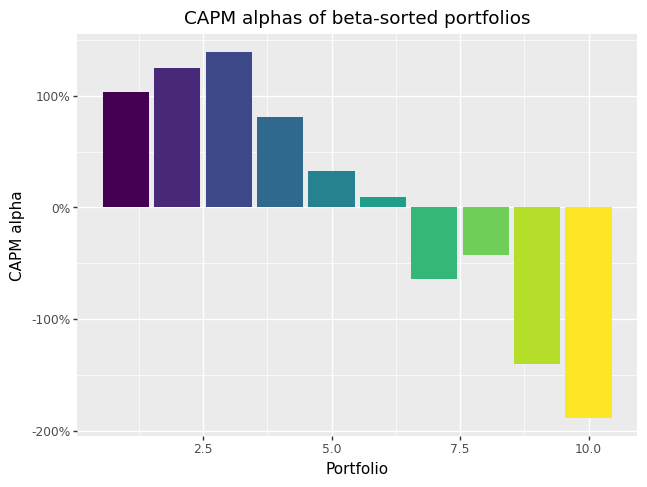

In [16]:
plot_beta_portfolios_summary = (
  ggplot(beta_portfolios_summary, 
         aes(x="portfolio", y="alpha", fill="portfolio")) +
  geom_bar(stat="identity") +
  labs(title="CAPM alphas of beta-sorted portfolios",
       x="Portfolio", y="CAPM alpha", fill="Portfolio") +
  scale_y_continuous(labels=percent_format()) +
  theme(legend_position="none")
)
plot_beta_portfolios_summary.draw()

这些结果表明，beta和未来股票回报之间存在负面关系，这与CAPM的预测相矛盾。根据CAPM，整个投资组合的回报应该随着beta的增加而增加，风险调整后的回报应该在统计学上无法与零区分开来。

### 6 证券市场线和beta投资组合
CAPM预测，我们的投资组合应该在证券市场线（SML）上。SML的斜率等于市场风险溢价，并反映了任何给定时间的风险回报权衡。下图说明了证券市场线：我们看到（毫不奇怪）高beta投资组合回报与市场回报高度相关。然而，高贝塔股票的平均超额回报似乎低于证券市场线包含的对高市场风险的“适当”补偿。

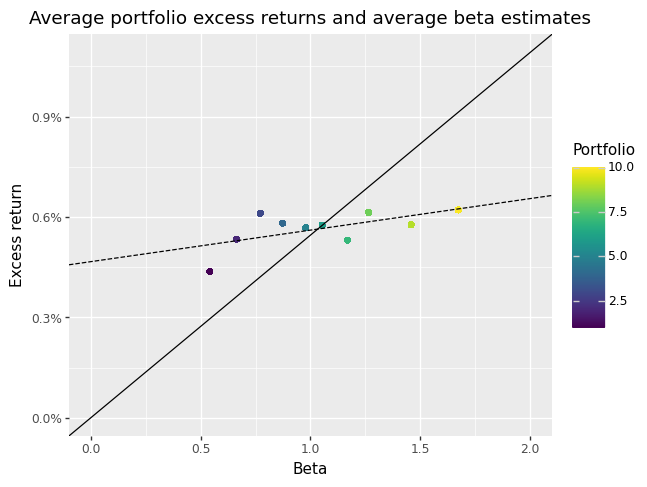

In [17]:
sml_capm = (sm.OLS.from_formula(
    formula="ret ~ 1 + beta", 
    data=beta_portfolios_summary
  )
  .fit()
  .params
)

plot_sml_capm = (
  ggplot(beta_portfolios_summary,
         aes(x="beta", y="ret", color="portfolio")) +
  geom_point() + 
  geom_abline(intercept=0,
              slope=factors_ff3_monthly["mkt_excess"].mean(),
              linetype="solid") +
  geom_abline(intercept=sml_capm["Intercept"],
                slope=sml_capm["beta"],
                linetype="dashed") +
  scale_y_continuous(
    labels=percent_format(),
    limits=(0, factors_ff3_monthly["mkt_excess"].mean()*2)
  ) +
  scale_x_continuous(limits=(0, 2)) +
  labs(x="Beta", y="Excess return", color="Portfolio",
       title= ("Average portfolio excess returns and "
               "average beta estimates"))
)
plot_sml_capm.draw()

为了提供更多证据来反对CAPM预测，我们再次形成了一个多头策略：购买高beta投资组合，做空低beta投资组合。

In [18]:
beta_portfolios1=beta_portfolios
print(beta_portfolios1['portfolio'].unique())
print(beta_portfolios1['portfolio'].dtype)

[ 1  2  3  4  5  6  7  8  9 10]
int64


In [19]:

# 1. 标记投资组合为 'high' 或 'low'
beta_portfolios1['portfolio'] = beta_portfolios1['portfolio'].astype(int)
beta_portfolios1['portfolio'] = beta_portfolios1['portfolio'].apply(
    lambda x: 'high' if x == beta_portfolios1['portfolio'].max() else ('low' if x == beta_portfolios1['portfolio'].min() else x)
)

# 2. 过滤出只包含 'high' 和 'low' 的行
filtered_beta_portfolios = beta_portfolios1[beta_portfolios1['portfolio'].isin(['low', 'high'])]

# 3. 重塑数据为宽格式
pivot_beta_portfolios = filtered_beta_portfolios.pivot(index='month', columns='portfolio', values='ret')

# 4. 计算 'long-short' 策略的收益
pivot_beta_portfolios['long_short'] = pivot_beta_portfolios['high'] - pivot_beta_portfolios['low']

# 5. 合并数据
beta_longshort1 = pivot_beta_portfolios.reset_index().merge(factors_ff3_monthly, how='left', on='month')
beta_longshort1.set_index('month', inplace=True)

# 查看结果
beta_longshort1

,high,low,long_short,mkt_excess,smb,hml,rf
month,,,,,,,
1965-02-01,0.066541,-0.020036,0.086577,0.0044,0.0355,0.0011,0.0030
1965-03-01,0.001868,-0.030838,0.032706,-0.0134,0.0189,0.0103,0.0036
1965-04-01,0.042072,0.005927,0.036145,0.0311,0.0110,0.0066,0.0031
1965-05-01,0.007530,-0.003941,0.011471,-0.0077,0.0011,-0.0161,0.0031
1965-06-01,-0.115000,-0.026275,-0.088725,-0.0551,-0.0434,0.0059,0.0035
...,...,...,...,...,...,...,...
2022-08-01,-0.042104,-0.024675,-0.017429,-0.0377,0.0140,0.0029,0.0019
2022-09-01,-0.079656,-0.052539,-0.027117,-0.0935,-0.0081,0.0005,0.0019
2022-10-01,-0.027566,0.078075,-0.105641,0.0783,0.0006,0.0801,0.0023


同样，由此产生的long-short策略没有表现出统计学上显著的回报。

In [20]:
# 使用 statsmodels 进行线性回归
model = smf.ols('long_short ~ 1', data=beta_longshort1).fit(cov_type='HAC', cov_kwds={'maxlags': 6})

# 打印回归结果及其稳健性标准误
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Nov 2024   Prob (F-statistic):                nan
Time:                        17:57:02   Log-Likelihood:                 791.51
No. Observations:                 695   AIC:                            -1581.
Df Residuals:                     694   BIC:                            -1576.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0018      0.003      0.588      0.5

In [21]:
prettify_result(model)

OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept     0.002       0.003        0.588    0.556

Summary statistics:
- Number of observations: 695
- R-squared: 0.000, Adjusted R-squared: 0.000
- F-statistic not available



然而，long-short投资组合产生了一个统计上显著的负CAPM调整后的alpha，尽管根据CAPM的影响，控制beta的影响后平均超额股票回报率应为零。因此，这些结果没有提供任何支持CAPM的证据。
Betting against beta相当于做空高beta股票并在低beta股票中采取（杠杆）多头头寸的策略。如果借款限制阻止投资者对SML持仓，他们反而被激励购买高beta股票，这导致此类高beta股票的价格相对较高（因此预期回报低于CAPM所表示的预期回报）。因此，Betting against beta策略通过向风险厌恶较低的资本约束投资者提供流动性中赚钱。

In [22]:
model_fit = (sm.OLS.from_formula(
    formula="long_short ~ 1 + mkt_excess", 
    data=beta_longshort1
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(model_fit)

OLS Model:
long_short ~ 1 + mkt_excess

Coefficients:
            Estimate  Std. Error  t-Statistic  p-Value
Intercept     -0.004       0.002       -1.870    0.061
mkt_excess     1.130       0.069       16.457    0.000

Summary statistics:
- Number of observations: 695
- R-squared: 0.440, Adjusted R-squared: 0.439
- F-statistic: 270.817 on 1 and 693 DF, p-value: 0.000



下图显示了我们主要感兴趣的极端beta投资组合的年度回报。该图说明了过去几年没有一致的惊人模式——每个投资组合都表现出具有正和负年回报的时期。

In [23]:
print(beta_longshort1.index)

DatetimeIndex(['1965-02-01', '1965-03-01', '1965-04-01', '1965-05-01',
               '1965-06-01', '1965-07-01', '1965-08-01', '1965-09-01',
               '1965-10-01', '1965-11-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='month', length=695, freq=None)


In [24]:
beta_longshort1 = beta_longshort1.reset_index()
print(beta_longshort1.index)

RangeIndex(start=0, stop=695, step=1)


In [25]:
beta_longshort1 = beta_longshort1.reset_index()
# 1. 按年计算累积乘积
beta_longshort1['year'] = pd.to_datetime(beta_longshort1['month']).dt.year
annual_returns = beta_longshort1.groupby('year').agg(
    low=('low', lambda x: (1 + x).prod()),
    high=('high', lambda x: (1 + x).prod()),
    long_short=('long_short', lambda x: (1 + x).prod())
)
annual_returns


,low,high,long_short
year,,,
1965,0.999161,1.424414,1.429124
1966,0.862291,1.001323,1.160683
1967,1.047481,1.322310,1.272486
1968,1.097451,1.169758,1.068011
1969,0.809099,0.656538,0.828528
1970,1.057492,0.707200,0.686163
1971,1.017261,1.153325,1.143022
1972,1.104636,0.947042,0.856983
1973,0.824488,0.516884,0.641696


In [26]:
# 2. 重塑数据为长格式
annual_returns_long = pd.melt(annual_returns.reset_index(), id_vars=['year'], var_name='name', value_name='value')
annual_returns_long

,year,name,value
0,1965,low,0.999161
1,1966,low,0.862291
2,1967,low,1.047481
3,1968,low,1.097451
4,1969,low,0.809099
...,...,...,...
169,2018,long_short,0.718834
170,2019,long_short,1.058449
171,2020,long_short,1.393284
172,2021,long_short,1.119613


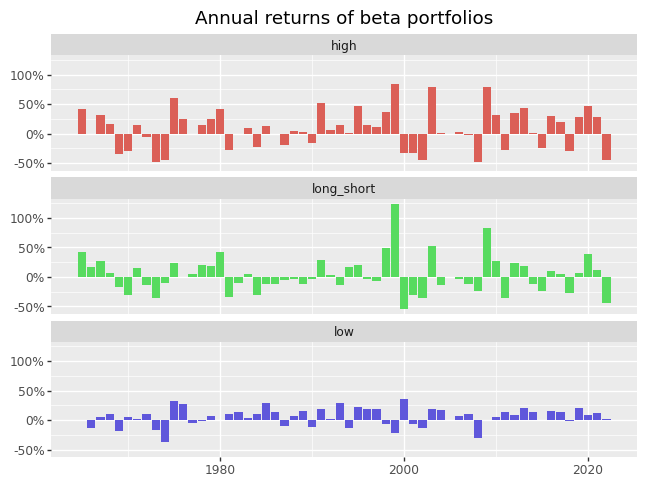

In [27]:
plot_beta_longshort_year = (
  ggplot(annual_returns_long, 
         aes(x="year", y="value-1", fill="name")) +  
  geom_col(position='dodge') +
  facet_wrap("~name", ncol=1) +
  theme(legend_position="none") +
  scale_color_discrete(guide=None) +
  scale_y_continuous(labels=percent_format()) +
  labs(x="", y="", title="Annual returns of beta portfolios")
)
plot_beta_longshort_year.draw()

1.Take the two long-short beta strategies based on different numbers of portfolios and compare the returns. Is there a significant difference in returns? How do the Sharpe ratios compare between the strategies? Find one additional portfolio evaluation statistic and compute it.
以两种基于不同投资组合数量的多空beta策略为例，比较它们的回报。回报有显著差异吗？不同策略的夏普比率比较起来如何？找到一个额外的投资组合评估统计并计算它。

In [28]:
beta_longshort #中间截断

portfolio,high,low,long_short
month,,,
1965-02-01,0.021093,-0.008176,0.029269
1965-03-01,-0.011273,-0.016682,0.005409
1965-04-01,0.042503,0.024768,0.017735
1965-05-01,-0.011181,-0.005542,-0.005639
1965-06-01,-0.062946,-0.045233,-0.017713
...,...,...,...
2022-08-01,-0.034495,-0.041749,0.007254
2022-09-01,-0.112782,-0.080497,-0.032286
2022-10-01,0.066806,0.087849,-0.021043


In [29]:
beta_longshort1 #分成10个组的1和10

,index,month,high,low,long_short,mkt_excess,smb,hml,rf,year
0,0,1965-02-01,0.066541,-0.020036,0.086577,0.0044,0.0355,0.0011,0.0030,1965
1,1,1965-03-01,0.001868,-0.030838,0.032706,-0.0134,0.0189,0.0103,0.0036,1965
2,2,1965-04-01,0.042072,0.005927,0.036145,0.0311,0.0110,0.0066,0.0031,1965
3,3,1965-05-01,0.007530,-0.003941,0.011471,-0.0077,0.0011,-0.0161,0.0031,1965
4,4,1965-06-01,-0.115000,-0.026275,-0.088725,-0.0551,-0.0434,0.0059,0.0035,1965
...,...,...,...,...,...,...,...,...,...,...
690,690,2022-08-01,-0.042104,-0.024675,-0.017429,-0.0377,0.0140,0.0029,0.0019,2022
691,691,2022-09-01,-0.079656,-0.052539,-0.027117,-0.0935,-0.0081,0.0005,0.0019,2022
692,692,2022-10-01,-0.027566,0.078075,-0.105641,0.0783,0.0006,0.0801,0.0023,2022
693,693,2022-11-01,-0.062898,0.054949,-0.117848,0.0460,-0.0352,0.0138,0.0029,2022


In [30]:
# 计算累积回报
cumulative_return_strategy1 = (1 + beta_longshort['long_short']).cumprod()[-1] - 1
cumulative_return_strategy2 = (1 + beta_longshort1['long_short']).prod() - 1

# 比较回报
t_stat, p_value = stats.ttest_ind(beta_longshort['long_short'].dropna(), beta_longshort1['long_short'].dropna())

# 显示结果
print("策略1 累积回报:", cumulative_return_strategy1)
print("策略2 累积回报:", cumulative_return_strategy2)
print("t检验统计量:", t_stat)
print("p值:", p_value)

# 检验是否显著
if p_value < 0.05:
    print("两种策略回报存在显著差异。")
else:
    print("两种策略回报不存在显著差异。")

策略1 累积回报: -0.30835783398522276
策略2 累积回报: -0.5483887747369549
t检验统计量: -0.5800910423414283
p值: 0.5619473770716501
两种策略回报不存在显著差异。


In [31]:
# 每个strategy计算一个夏普比例直接比较
# 计算夏普比率的函数
def calculate_sharpe_ratio(excess_returns):
    return np.mean(excess_returns) / np.std(excess_returns)

# 计算两种策略的夏普比率
sharpe_ratio_strategy1 = calculate_sharpe_ratio(beta_longshort['long_short'])
sharpe_ratio_strategy2 = calculate_sharpe_ratio(beta_longshort1['long_short'])

# 显示结果
print("策略1 的夏普比率:", sharpe_ratio_strategy1)
print("策略2 的夏普比率:", sharpe_ratio_strategy2)

# 比较夏普比率
if sharpe_ratio_strategy1 > sharpe_ratio_strategy2:
    print("策略1 的风险调整回报更高。")
elif sharpe_ratio_strategy1 < sharpe_ratio_strategy2:
    print("策略2 的风险调整回报更高。")
else:
    print("两种策略的风险调整回报相同。")

策略1 的夏普比率: -0.0003055100678428672
策略2 的夏普比率: 0.023719865764674695
策略2 的风险调整回报更高。


In [32]:
# 用滚动窗口计算夏普比率，用统计意义上比较夏普比率
beta_longshort1.set_index('month', inplace=True)

# 设置滚动窗口大小（一年）
window_size = 12

# 计算年化收益率和标准差
def annualized_metrics(returns):
    annualized_return = (1 + returns).rolling(window=window_size).apply(lambda x: x.prod())**(12/window_size) - 1
    annualized_std = returns.rolling(window=window_size).std() * (12**0.5)
    return annualized_return, annualized_std

# 计算年化收益率和标准差
annualized_return1, annualized_std1 = annualized_metrics(beta_longshort['long_short'])
annualized_return2, annualized_std2 = annualized_metrics(beta_longshort1['long_short'])

annualized_return1, annualized_std1,annualized_return2, annualized_std2

(month
 1965-02-01         NaN
 1965-03-01         NaN
 1965-04-01         NaN
 1965-05-01         NaN
 1965-06-01         NaN
                 ...   
 2022-08-01   -0.003797
 2022-09-01   -0.061968
 2022-10-01   -0.105798
 2022-11-01   -0.146100
 2022-12-01   -0.157882
 Name: long_short, Length: 695, dtype: float64,
 month
 1965-02-01         NaN
 1965-03-01         NaN
 1965-04-01         NaN
 1965-05-01         NaN
 1965-06-01         NaN
                 ...   
 2022-08-01    0.138797
 2022-09-01    0.138883
 2022-10-01    0.135238
 2022-11-01    0.135976
 2022-12-01    0.139175
 Name: long_short, Length: 695, dtype: float64,
 month
 1965-02-01         NaN
 1965-03-01         NaN
 1965-04-01         NaN
 1965-05-01         NaN
 1965-06-01         NaN
                 ...   
 2022-08-01   -0.153690
 2022-09-01   -0.227040
 2022-10-01   -0.317967
 2022-11-01   -0.383526
 2022-12-01   -0.447780
 Name: long_short, Length: 695, dtype: float64,
 month
 1965-02-01         NaN
 1965-03-01 

In [33]:
annualized_return1.isna().sum()

11

In [34]:
# 计算Sharpe比率
sharpe_ratio1 = (annualized_return1) / annualized_std1
sharpe_ratio2 = (annualized_return2) / annualized_std2
sharpe_ratio_compare = sharpe_ratio1-sharpe_ratio2 
sharpe_ratio_compare = sharpe_ratio_compare.dropna()
sharpe_ratio_compare

month
1966-01-01   -0.215959
1966-02-01   -0.225833
1966-03-01    0.015646
1966-04-01    0.040570
1966-05-01    0.241456
                ...   
2022-08-01    0.400790
2022-09-01    0.202703
2022-10-01    0.103864
2022-11-01   -0.038286
2022-12-01   -0.012793
Name: long_short, Length: 684, dtype: float64

In [35]:
sharpe_ratio_fit = (sm.OLS.from_formula(
    formula="sharpe_ratio_compare ~ 1", 
    data=sharpe_ratio_compare
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(sharpe_ratio_fit)

OLS Model:
sharpe_ratio_compare ~ 1

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept    -0.031        0.03       -1.046    0.296

Summary statistics:
- Number of observations: 684
- R-squared: -0.000, Adjusted R-squared: -0.000
- F-statistic not available



Calmar比率是一种衡量投资表现的指标，特别是在考虑投资风险时。它是年化收益率与最大回撤之间的比率。Calmar比率越高，意味着投资回报相对于其风险（即最大回撤）越好。Calmar比率的计算公式为：

Calmar比率=年化收益率/最大回撤

其中最大回撤是指投资组合价值从峰值下降到谷底的最大幅度下降。

In [36]:
def calculate_max_drawdown(returns_series):
    """
    计算最大回撤
    :param returns_series: Pandas Series，包含收益率数据
    :return: 最大回撤
    """
    wealth_index = (1 + returns_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdown.min()
    return max_drawdown

def calculate_calmar_ratio(returns_series):
    """
    计算Calmar比率
    :param returns_series: Pandas Series，包含收益率数据
    :return: Calmar比率
    """
    annualized_return = (1 + returns_series).prod()**(12/len(returns_series)) - 1
    print("Annualized Return:", annualized_return)  # 打印年化回报率
    max_drawdown = calculate_max_drawdown(returns_series)
    calmar_ratio = annualized_return / -max_drawdown
    return calmar_ratio

calmar_ratio1 = calculate_calmar_ratio(beta_longshort['long_short'])
calmar_ratio2 = calculate_calmar_ratio(beta_longshort1['long_short'])
print("Calmar比率1:", calmar_ratio1)
print("Calmar比率2:", calmar_ratio2)

Annualized Return: -0.006345592228098607
Annualized Return: -0.013631707251176906
Calmar比率1: -0.009632929635980515
Calmar比率2: -0.015548682912673228


Calmar比率越高，意味着投资回报相对于其风险（即最大回撤）越好。

Calmar 比率本身是年化回报和最大回撤的比值，理论上它应该是一个正值。
如果年化回报是负数并且最大回撤也是负数（回撤是亏损），那么 Calmar比率会是负数。但从投资策略的角度看，负的 Calmar比率 并没有实际意义，通常是表示策略表现不佳。

2.We plotted the alphas of the ten beta portfolios above. Write a function that tests these estimates for significance. Which portfolios have significant alphas?
我们绘制了上面10个贝塔投资组合的阿尔法。编写一个函数来测试这些估计的显著性。哪些投资组合有显著的α ？

In [37]:
alpha_test = (beta_portfolios
  .groupby("portfolio", group_keys=False)
  .apply(lambda x: x.assign(
    alpha=sm.OLS.from_formula(
      formula="ret ~ 1 + mkt_excess", 
      data=x
      ).fit().params[0],
    alpha_pvalue=sm.OLS.from_formula(
      formula="ret ~ 1 + mkt_excess", 
      data=x
      ).fit().pvalues[0]
    ).tail(1)
  .get(["portfolio","alpha","alpha_pvalue"])
  .reset_index(drop=True) 
)
)
alpha_test

,portfolio,alpha,alpha_pvalue
0,2,0.001799,0.026126
0,3,0.001996,0.008698
0,4,0.001159,0.100725
0,5,0.000465,0.483803
0,6,0.000138,0.841762
0,7,-0.000922,0.198490
0,8,-0.000611,0.438261
0,9,-0.002010,0.071188
0,high,-0.002708,0.083029
0,low,0.001480,0.157151


3.The analysis here is based on betas from monthly returns. However, we also computed betas from daily returns. Re-run the analysis and point out differences in the results.这里的分析是基于月度回报的beta值。然而，我们也从日收益中计算了贝塔系数。重新运行分析并指出结果中的差异。

In [38]:
beta_lag_daily = (beta
  .assign(
    month = lambda x: x["month"] + pd.DateOffset(months=1)
  )
  .get(["permno", "month", "beta_daily"])
  .rename(columns={"beta_daily": "beta_lag"})
  .dropna()
)

data_for_sorts_daily = pd.merge(crsp_monthly, beta_lag_daily, how="inner", on=["permno", "month"])

In [39]:
data_for_sorts_daily

,permno,month,ret_excess,mktcap_lag,beta_lag
0,10000,1986-05-01,-0.227556,15.172000,0.005527
1,10000,1986-06-01,-0.010225,11.793859,0.003349
2,10000,1986-07-01,-0.086008,11.734594,-0.020345
3,10000,1986-08-01,-0.619985,10.786344,0.600559
4,10000,1986-09-01,-0.061643,4.148594,0.650888
...,...,...,...,...,...
3254316,93436,2022-08-01,-0.074389,931110.623250,2.129350
3254317,93436,2022-09-01,-0.039489,863615.620800,1.702458
3254318,93436,2022-10-01,-0.144468,837659.500000,1.515607
3254319,93436,2022-11-01,-0.147226,718514.868879,1.265084


In [40]:
breakpoint_daily = data_for_sorts_daily.groupby("month").median(numeric_only=True)['beta_lag']
df_daily = pd.merge(data_for_sorts_daily, breakpoint_daily, how='inner', on='month')
# 按中间值分成high和low的portfolio
df_daily['portfolio'] = 'low'
df_daily.loc[(df_daily['beta_lag_x'] > df_daily['beta_lag_y']), 'portfolio'] = 'high'
df_daily

,permno,month,ret_excess,mktcap_lag,beta_lag_x,beta_lag_y,portfolio
0,10000,1986-05-01,-0.227556,15.172000,0.005527,0.431178,low
1,10000,1986-06-01,-0.010225,11.793859,0.003349,0.406721,low
2,10000,1986-07-01,-0.086008,11.734594,-0.020345,0.433122,low
3,10000,1986-08-01,-0.619985,10.786344,0.600559,0.548964,high
4,10000,1986-09-01,-0.061643,4.148594,0.650888,0.556579,high
...,...,...,...,...,...,...,...
3254316,93436,2022-08-01,-0.074389,931110.623250,2.129350,0.928501,high
3254317,93436,2022-09-01,-0.039489,863615.620800,1.702458,0.914713,high
3254318,93436,2022-10-01,-0.144468,837659.500000,1.515607,0.913048,high
3254319,93436,2022-11-01,-0.147226,718514.868879,1.265084,0.916224,high


In [41]:
beta_portfolio_daily = df_daily.groupby(['month','portfolio'], as_index=False).apply(lambda x: np.average(x['ret_excess'], weights=x['mktcap_lag']))
beta_portfolio_daily.columns = ['month','portfolio','ret'] 
beta_portfolio_daily

,month,portfolio,ret
0,1960-04-01,high,-0.020979
1,1960-04-01,low,-0.007969
2,1960-05-01,high,0.033517
3,1960-05-01,low,0.025396
4,1960-06-01,high,0.012889
...,...,...,...
1501,2022-10-01,low,0.107083
1502,2022-11-01,high,0.046962
1503,2022-11-01,low,0.044942
1504,2022-12-01,high,-0.086568


In [42]:
beta_longshort_daily = beta_portfolio_daily.pivot(index = 'month', columns = "portfolio", values = "ret")
beta_longshort_daily['long_short'] = beta_longshort_daily['high']-beta_longshort_daily['low']
beta_longshort_daily

portfolio,high,low,long_short
month,,,
1960-04-01,-0.020979,-0.007969,-0.013010
1960-05-01,0.033517,0.025396,0.008121
1960-06-01,0.012889,0.037422,-0.024533
1960-07-01,-0.024233,-0.022391,-0.001842
1960-08-01,0.019254,0.049471,-0.030217
...,...,...,...
2022-08-01,-0.044796,-0.029932,-0.014864
2022-09-01,-0.111168,-0.070525,-0.040643
2022-10-01,0.053899,0.107083,-0.053184


In [43]:
# 使用 statsmodels 公式 API 进行线性回归
model_fit = smf.ols('long_short ~ 1', data=beta_longshort_daily).fit(cov_type='HAC', cov_kwds={'maxlags': 6}) # bandwith为6

# 打印回归系数及其稳健性标准误
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:             long_short   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 27 Nov 2024   Prob (F-statistic):                nan
Time:                        17:57:07   Log-Likelihood:                 1579.9
No. Observations:                 753   AIC:                            -3158.
Df Residuals:                     752   BIC:                            -3153.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.001     -0.512      0.6

In [44]:
def assign_portfolio(data, sorting_variable, n_portfolios):
    # 计算分位数并分配投资组合编号
    breakpoints = pd.qcut(data[sorting_variable], q=n_portfolios, labels=False, duplicates='drop') + 1
    return breakpoints

data_for_sorts_daily['month'] = pd.to_datetime(data_for_sorts_daily['month'])

# 1. 为每个月分配投资组合
data_for_sorts_daily['portfolio'] = data_for_sorts_daily.groupby('month').apply(
    lambda x: assign_portfolio(x, 'beta_lag', 10)
).reset_index(level=0, drop=True)

# 2. 计算每个投资组合每月的加权平均超额收益
grouped_daily = data_for_sorts_daily.groupby(['portfolio', 'month'])
beta_portfolios_daily = grouped_daily.apply(lambda x: pd.Series({
    'ret': np.average(x['ret_excess'], weights=x['mktcap_lag'])
})).reset_index()

# 3. 与 factors_ff3_monthly DataFrame 合并
beta_portfolios_daily = beta_portfolios_daily.merge(factors_ff3_monthly, how='left', on='month')

# 查看结果
print(beta_portfolios_daily)

      portfolio      month       ret  mkt_excess     smb     hml      rf
0             1 1960-04-01  0.000925     -0.0171  0.0032 -0.0228  0.0019
1             1 1960-05-01  0.006730      0.0312  0.0121 -0.0370  0.0027
2             1 1960-06-01  0.043627      0.0208 -0.0021 -0.0034  0.0024
3             1 1960-07-01 -0.024490     -0.0237 -0.0051  0.0198  0.0013
4             1 1960-08-01  0.039714      0.0301  0.0087 -0.0018  0.0017
...         ...        ...       ...         ...     ...     ...     ...
7525         10 2022-08-01 -0.058725     -0.0377  0.0140  0.0029  0.0019
7526         10 2022-09-01 -0.133756     -0.0935 -0.0081  0.0005  0.0019
7527         10 2022-10-01  0.041941      0.0783  0.0006  0.0801  0.0023
7528         10 2022-11-01  0.071181      0.0460 -0.0352  0.0138  0.0029
7529         10 2022-12-01 -0.127725     -0.0641 -0.0069  0.0137  0.0033

[7530 rows x 7 columns]


In [45]:
# 1. 定义执行线性回归的函数
def run_regression(group):
    model = LinearRegression()
    X = group[['mkt_excess']]  # 作为自变量
    y = group['ret']           # 作为因变量
    model.fit(X, y)
    alpha = model.intercept_
    beta = model.coef_[0]
    return pd.Series({'alpha': alpha, 'beta': beta, 'ret': group['ret'].mean()})

# 3. 对每个投资组合执行线性回归并计算平均收益率
beta_portfolios_summary_daily = beta_portfolios_daily.groupby('portfolio').apply(run_regression).reset_index()

# 查看结果
print(beta_portfolios_summary_daily)

   portfolio     alpha      beta       ret
0          1 -0.001003  0.706798  0.002939
1          2  0.002360  0.658505  0.006033
2          3  0.001888  0.708090  0.005837
3          4  0.001632  0.766859  0.005909
4          5  0.001756  0.834674  0.006412
5          6  0.000737  0.884777  0.005672
6          7  0.000544  0.987513  0.006052
7          8 -0.000496  1.111392  0.005703
8          9 -0.002026  1.266800  0.005040
9         10 -0.005794  1.600004  0.003130


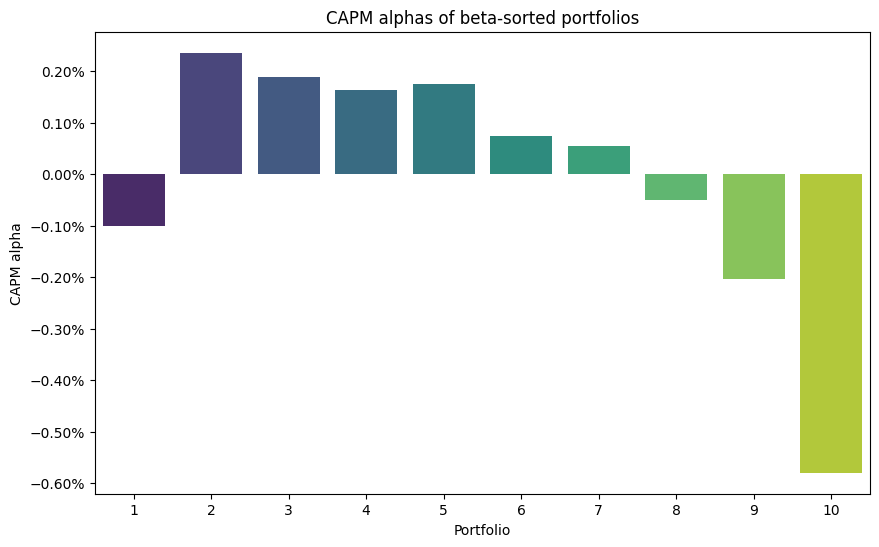

In [46]:
# 创建条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='portfolio', y='alpha', data=beta_portfolios_summary_daily, palette='viridis')

# 设置标题和坐标轴标签
plt.title('CAPM alphas of beta-sorted portfolios')
plt.xlabel('Portfolio')
plt.ylabel('CAPM alpha')

# 设置y轴的格式为百分比
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# 移除图例
plt.legend([],[], frameon=False)

# 显示图表
plt.show()

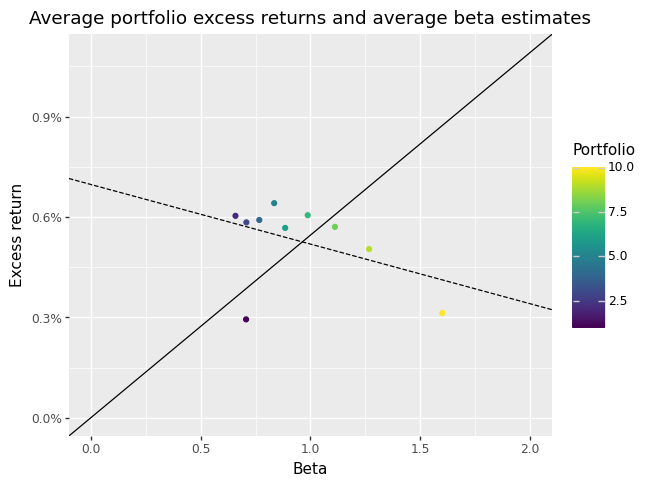

In [47]:
sml_capm = (sm.OLS.from_formula(
    formula="ret ~ 1 + beta", 
    data=beta_portfolios_summary_daily
  )
  .fit()
  .params
)

plot_sml_capm = (
  ggplot(beta_portfolios_summary_daily,
         aes(x="beta", y="ret", color="portfolio")) +
  geom_point() + 
  geom_abline(intercept=0,
              slope=factors_ff3_monthly["mkt_excess"].mean(),
              linetype="solid") +
  geom_abline(intercept=sml_capm["Intercept"],
                slope=sml_capm["beta"],
                linetype="dashed") +
  scale_y_continuous(
    labels=percent_format(),
    limits=(0, factors_ff3_monthly["mkt_excess"].mean()*2)
  ) +
  scale_x_continuous(limits=(0, 2)) +
  labs(x="Beta", y="Excess return", color="Portfolio",
       title= ("Average portfolio excess returns and "
               "average beta estimates"))
)
plot_sml_capm.draw()

In [48]:
# 1. 标记投资组合为 'high' 或 'low'
beta_portfolios_daily['portfolio'] = beta_portfolios_daily['portfolio'].astype(str).astype(int)
beta_portfolios_daily['portfolio'] = beta_portfolios_daily['portfolio'].apply(
    lambda x: 'high' if x == beta_portfolios_daily['portfolio'].max() else ('low' if x == beta_portfolios_daily['portfolio'].min() else x)
)

# 2. 过滤出只包含 'high' 和 'low' 的行
filtered_beta_portfolios = beta_portfolios_daily[beta_portfolios_daily['portfolio'].isin(['low', 'high'])]

# 3. 重塑数据为宽格式
pivot_beta_portfolios = filtered_beta_portfolios.pivot(index='month', columns='portfolio', values='ret')

# 4. 计算 'long-short' 策略的收益
pivot_beta_portfolios['long_short'] = pivot_beta_portfolios['high'] - pivot_beta_portfolios['low']

# 5. 合并数据
beta_longshort1_daily = pivot_beta_portfolios.reset_index().merge(factors_ff3_monthly, how='left', on='month')
beta_longshort1_daily.set_index('month', inplace=True)

# 查看结果
beta_longshort1_daily

,high,low,long_short,mkt_excess,smb,hml,rf
month,,,,,,,
1960-04-01,-0.024709,0.000925,-0.025634,-0.0171,0.0032,-0.0228,0.0019
1960-05-01,0.061740,0.006730,0.055010,0.0312,0.0121,-0.0370,0.0027
1960-06-01,-0.004548,0.043627,-0.048175,0.0208,-0.0021,-0.0034,0.0024
1960-07-01,-0.025532,-0.024490,-0.001042,-0.0237,-0.0051,0.0198,0.0013
1960-08-01,0.013207,0.039714,-0.026507,0.0301,0.0087,-0.0018,0.0017
...,...,...,...,...,...,...,...
2022-08-01,-0.058725,0.000962,-0.059687,-0.0377,0.0140,0.0029,0.0019
2022-09-01,-0.133756,-0.013222,-0.120533,-0.0935,-0.0081,0.0005,0.0019
2022-10-01,0.041941,0.006110,0.035831,0.0783,0.0006,0.0801,0.0023


In [49]:
# 使用 statsmodels 进行线性回归
model = smf.ols('long_short ~ 1', data=beta_longshort1_daily).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# 打印回归结果及其稳健性标准误
prettify_result(model)

OLS Model:
long_short ~ 1

Coefficients:
           Estimate  Std. Error  t-Statistic  p-Value
Intercept       0.0       0.002        0.079    0.937

Summary statistics:
- Number of observations: 753
- R-squared: -0.000, Adjusted R-squared: -0.000
- F-statistic not available



In [50]:
model_fit = (sm.OLS.from_formula(
    formula="long_short ~ 1 + mkt_excess", 
    data=beta_longshort1_daily
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(model_fit)

OLS Model:
long_short ~ 1 + mkt_excess

Coefficients:
            Estimate  Std. Error  t-Statistic  p-Value
Intercept     -0.005       0.002       -2.176     0.03
mkt_excess     0.893       0.080       11.135     0.00

Summary statistics:
- Number of observations: 753
- R-squared: 0.349, Adjusted R-squared: 0.348
- F-statistic: 123.989 on 1 and 751 DF, p-value: 0.000



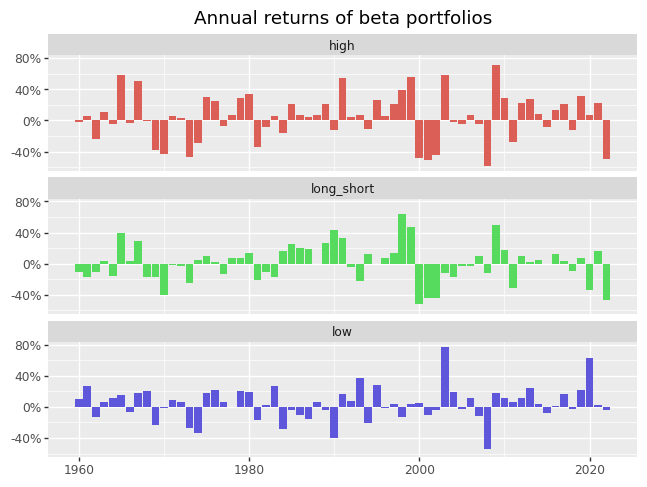

In [51]:
beta_longshort1_daily = beta_longshort1_daily.reset_index()
# 1. 按年计算累积乘积
beta_longshort1_daily['year'] = pd.to_datetime(beta_longshort1_daily['month']).dt.year
annual_returns = beta_longshort1_daily.groupby('year').agg(
    low=('low', lambda x: (1 + x).prod()),
    high=('high', lambda x: (1 + x).prod()),
    long_short=('long_short', lambda x: (1 + x).prod())
)

# 2. 重塑数据为长格式
annual_returns_long = pd.melt(annual_returns.reset_index(), id_vars=['year'], var_name='name', value_name='value')

plot_beta_longshort_year = (
  ggplot(annual_returns_long, 
         aes(x="year", y="value-1", fill="name")) +  
  geom_col(position='dodge') +
  facet_wrap("~name", ncol=1) +
  theme(legend_position="none") +
  scale_color_discrete(guide=None) +
  scale_y_continuous(labels=percent_format()) +
  labs(x="", y="", title="Annual returns of beta portfolios")
)
plot_beta_longshort_year.draw()

4.Given the results in this chapter, can you define a long-short strategy that yields positive abnormal returns (i.e., alphas)? Plot the cumulative excess return of your strategy and the market excess return for comparison.考虑到本章的结果，你能定义一个产生正异常回报（即阿尔法）的多空策略吗？将你的策略的累积超额回报与市场超额回报进行比较。

要让long_short～1+mkt_excess的截距项显著且大于0，感觉不能通过beta分层，要么构造别的因子，要么选用多种资产构造

尝试了分更多层和percentile(0, 0.3, 0.7, 1)等分层方式均不成功，mktcap_lag等因子分层也不成功

最终选用夏普比率

In [52]:
#定义夏普比率计算函数
def sharpe_ratio(ret_excess):
    ret_excess_mean = np.mean(ret_excess)
    ret_excess_sd = np.std(ret_excess)
    sharpe_ratio = ret_excess_mean/ret_excess_sd
    return sharpe_ratio

#以一年作为计算的窗口期
window_size = 12

#滚动计算夏普比率
sharpe = (crsp_monthly
        .get(["permno","month","ret_excess"])
        .assign(sharpe_ratio=lambda x: x["ret_excess"].rolling(window = window_size).apply(lambda y: sharpe_ratio(y)))
        .dropna()
        )
sharpe

,permno,month,ret_excess,sharpe_ratio
11,10000,1987-01-01,-0.216321,-0.648728
12,10000,1987-02-01,-0.004300,-0.554445
13,10000,1987-03-01,-0.389315,-1.010305
14,10000,1987-04-01,-0.066900,-0.985261
15,10000,1987-05-01,-0.070467,-0.906140
...,...,...,...,...
3326348,93436,2022-08-01,-0.074389,0.134175
3326349,93436,2022-09-01,-0.039489,0.093314
3326350,93436,2022-10-01,-0.144468,-0.203407
3326351,93436,2022-11-01,-0.147226,-0.296549


In [53]:
#将夏普比率滞后一期，作为分组的排序变量
sharpe_lag = (sharpe
  .assign(
    month = lambda x: x["month"] + pd.DateOffset(months=1)  
  )
  .get(["permno", "month", "sharpe_ratio"])
  .rename(columns={"sharpe_ratio": "sharpe_lag"})
  .dropna()
)

data_for_sorts_new = (crsp_monthly
  .merge(sharpe_lag, 
         how="inner", 
         on=["permno", "month"])
)
data_for_sorts_new

,permno,month,ret_excess,mktcap_lag,sharpe_lag
0,10000,1987-02-01,-0.004300,1.581531,-0.648728
1,10000,1987-03-01,-0.389315,1.581531,-0.554445
2,10000,1987-04-01,-0.066900,0.973250,-1.010305
3,10000,1987-05-01,-0.070467,0.912422,-0.985261
4,10001,1986-03-01,0.019200,6.156250,-0.886387
...,...,...,...,...,...
3296387,93436,2022-08-01,-0.074389,931110.623250,0.199283
3296388,93436,2022-09-01,-0.039489,863615.620800,0.134175
3296389,93436,2022-10-01,-0.144468,837659.500000,0.093314
3296390,93436,2022-11-01,-0.147226,718514.868879,-0.203407


In [54]:
def assign_portfolio(data, sorting_variable, n_portfolios):
    breakpoints = np.quantile(
      data[sorting_variable].dropna(), 
      np.linspace(0, 1, n_portfolios + 1),
      method="linear" 
    )
    
    assigned_portfolios = pd.cut(
      data[sorting_variable],
      bins=breakpoints,
      labels=range(1, breakpoints.size), 
      include_lowest=True   
    )
    
    return assigned_portfolios

In [55]:
#根据滞后的夏普比率进行分组
sharpe_portfolios = (data_for_sorts_new
  .groupby("month", group_keys=False)
  .apply(lambda x: x.assign(
    portfolio = assign_portfolio(x, 'sharpe_lag', 10)
    )
  )
  .groupby(["portfolio", "month"], group_keys=False)
  .apply(lambda x: x.assign(
    ret=np.average(x["ret_excess"], weights=x["mktcap_lag"])
    )  
  )
)
sharpe_portfolios

,permno,month,ret_excess,mktcap_lag,sharpe_lag,portfolio,ret
0,10000,1987-02-01,-0.004300,1.581531,-0.648728,1,0.074852
1,10000,1987-03-01,-0.389315,1.581531,-0.554445,1,0.048436
2,10000,1987-04-01,-0.066900,0.973250,-1.010305,1,-0.063200
3,10000,1987-05-01,-0.070467,0.912422,-0.985261,1,0.001784
4,10001,1986-03-01,0.019200,6.156250,-0.886387,1,0.019025
...,...,...,...,...,...,...,...
3296387,93436,2022-08-01,-0.074389,931110.623250,0.199283,9,-0.028100
3296388,93436,2022-09-01,-0.039489,863615.620800,0.134175,8,-0.092108
3296389,93436,2022-10-01,-0.144468,837659.500000,0.093314,9,0.035262
3296390,93436,2022-11-01,-0.147226,718514.868879,-0.203407,5,0.067153


In [56]:
#构建新的多空投资组合
sharpe_longshort_new = (sharpe_portfolios
  .assign(
    portfolio=lambda x: (
      x["portfolio"].apply(
        lambda y: "high" if y == x["portfolio"].max()
        else ("low" if y == x["portfolio"].min()
        else y)
      )
    )
  )
  .query("portfolio in ['low', 'high']")
  .pivot_table(index="month", 
               columns="portfolio", 
               values="ret")
  .assign(long_short_new=lambda x: x["high"] - x["low"])
  .merge(factors_ff3_monthly, how="left", on="month")
)
sharpe_longshort_new

,month,low,high,long_short_new,mkt_excess,smb,hml,rf
0,1960-03-01,-0.030112,-0.020323,0.009789,-0.0163,-0.0049,-0.0294,0.0035
1,1960-04-01,-0.009053,-0.001179,0.007874,-0.0171,0.0032,-0.0228,0.0019
2,1960-05-01,0.036410,0.041777,0.005367,0.0312,0.0121,-0.0370,0.0027
3,1960-06-01,0.021741,0.024895,0.003154,0.0208,-0.0021,-0.0034,0.0024
4,1960-07-01,-0.012494,-0.044541,-0.032048,-0.0237,-0.0051,0.0198,0.0013
...,...,...,...,...,...,...,...,...
749,2022-08-01,-0.053692,-0.005396,0.048296,-0.0377,0.0140,0.0029,0.0019
750,2022-09-01,-0.145036,-0.071965,0.073071,-0.0935,-0.0081,0.0005,0.0019
751,2022-10-01,0.045797,0.141726,0.095929,0.0783,0.0006,0.0801,0.0023
752,2022-11-01,0.117785,0.012936,-0.104849,0.0460,-0.0352,0.0138,0.0029


In [57]:
#估计新的投资组合的alpha
model_fit = (sm.OLS.from_formula(
    formula="long_short_new ~ 1 + mkt_excess", 
    data=sharpe_longshort_new
  )
  .fit(cov_type="HAC", cov_kwds={"maxlags": 1})
)
prettify_result(model_fit)

OLS Model:
long_short_new ~ 1 + mkt_excess

Coefficients:
            Estimate  Std. Error  t-Statistic  p-Value
Intercept      0.009       0.002        4.260      0.0
mkt_excess    -0.296       0.069       -4.303      0.0

Summary statistics:
- Number of observations: 754
- R-squared: 0.049, Adjusted R-squared: 0.048
- F-statistic: 18.518 on 1 and 752 DF, p-value: 0.000

